## PSA-GAN in XGen Time Series

In [56]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
rc = {
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '.8',
      'font.size' : 15}
plt.rcParams.update(rc)
np.random.seed(sum(map(ord, 'aesthetics')))
sns.set()
import metrics
import progressive_blocks
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import utils
from models import CCGAN
from ModelConfig import XGenTrainingConfig
from pipelines import TrainingPipeline

Text(0, 0.5, 'Scaled Energy')

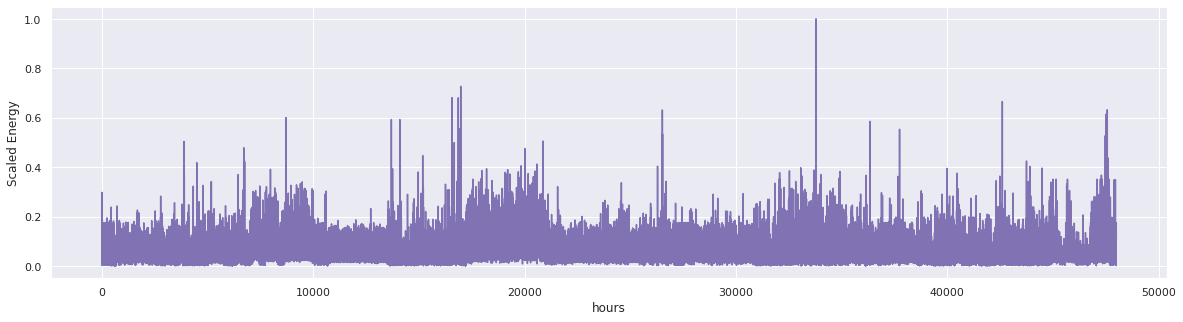

In [57]:
training_set = pd.read_csv('./archive/energy_france/Train/Monthly-train.csv')
training_set = training_set.iloc[:,1:2]
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
plt.figure(figsize=(20,5))
plt.plot(training_set, 'm')
plt.xlabel("hours")
plt.ylabel("Scaled Energy")

Text(0, 0.5, 'Scaled Energy')

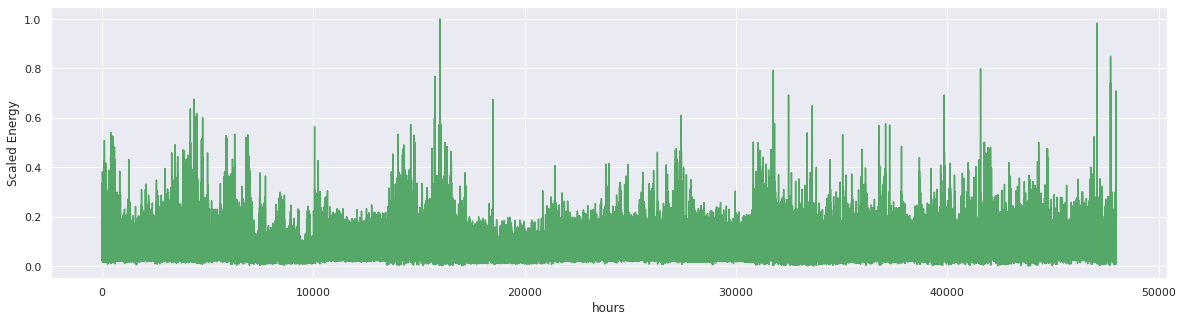

In [58]:
testing_set = pd.read_csv('./archive/energy_france/Test/Monthly-test.csv')
testing_set = testing_set.iloc[:,1:2] 
sc = MinMaxScaler()
testing_set = sc.fit_transform(testing_set)
plt.figure(figsize=(20,5))
plt.plot(testing_set, 'g')
plt.xlabel("hours")
plt.ylabel("Scaled Energy")

In [59]:
seq_length = 512 #it is tau in our NeurIPS paper
train_set=training_set[:42500]
x_train, y_train = utils.sliding_windows(train_set, seq_length)
trainX=torch.Tensor(np.array(x_train))
size=trainX.size(0)
sequences_train=utils.real_seq(training_set,seq_length)
sequences_train=sequences_train[:size]

sequences_train=torch.Tensor(sequences_train)
sequences_train.unsqueeze(0).unsqueeze(1)
sequences_train=sequences_train.permute(0,2,1)
print("Sequences_train.shape",sequences_train.shape)

Sequences_train.shape torch.Size([41987, 1, 512])


In [60]:
test_set=testing_set[:42500]
print(test_set.shape)

x_test, y_test= utils.sliding_windows(test_set, seq_length)
testX=torch.Tensor(np.array(x_test))
print("testX.shape:",testX.shape)
size=testX.size(0)

sequences_test=utils.real_seq(testing_set,seq_length)
sequences_test=sequences_test[:size]

sequences_test=torch.Tensor(sequences_test)
sequences_test.unsqueeze(0).unsqueeze(1)
sequences_test=sequences_test.permute(0,2,1)
print("Sequences_test.shape",sequences_test.shape)

(42500, 1)
testX.shape: torch.Size([41987, 512, 1])
Sequences_test.shape torch.Size([41987, 1, 512])


In [61]:
test_loader = DataLoader(test, batch_size=121, shuffle=False)
L = next(iter(test_loader)) #.shape
L[0].shape

torch.Size([121, 512, 1])

In [62]:
test= TensorDataset(testX, sequences_test)
test_loader = DataLoader(test, batch_size=121, shuffle=False)
embedder=torch.load("Models/Embedder/embedder_model.pt", map_location=torch.device('cpu'))

In [68]:
config_model = XGenTrainingConfig()
my_model = CCGAN(**config_model)

Cuda not available: using CPU


In [72]:
# Set up the training configuration
my_training_config = XGenTrainingConfig(output_dir='my_model',
                    num_epochs=50,
                    learning_rate=1e-3,
                    per_device_train_batch_size=100,
                    per_device_eval_batch_size=100,
                    train_dataloader_num_workers=0,
                    eval_dataloader_num_workers=0,
                    steps_saving='auto',
                    optimizer_cls="Adamax",
                    optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
                    scheduler_cls="ReduceLROnPlateau",
                    scheduler_params={"patience": 5, "factor": 0.5})



In [70]:
pipline = TrainingPipeline(training_config=my_training_config, model= my_model)

Cuda not available: using CPU


Cuda not available: using CPU
Directory already exists: Models/M4/BaseModel/

Starting training: BaseModel
Total Epochs: 100 
Blocks to add with fade: 2
Timestamp to add blocks: 5
Fade-in True
ML True
SA True


Training, Epoch:4/100: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s, Epoch=4, D loss=0.871, G loss=0.871, Fade-in:=1, FID=3.12e-5]


Block added


Training, Epoch:9/100: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it, Epoch=9, D loss=0.87, G loss=0.87, Fade-in:=1, FID=4.93e-5]


Block added


Training, Epoch:100/100: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it, Epoch=100, D loss=0.862, G loss=0.862, Fade-in:=1, FID=4.68e-6]


End-training Generator Loss: tensor(0.9180)
End-training Discriminator Loss: tensor(0.8622)
End-training Context-FID: tensor(4.6773e-06)


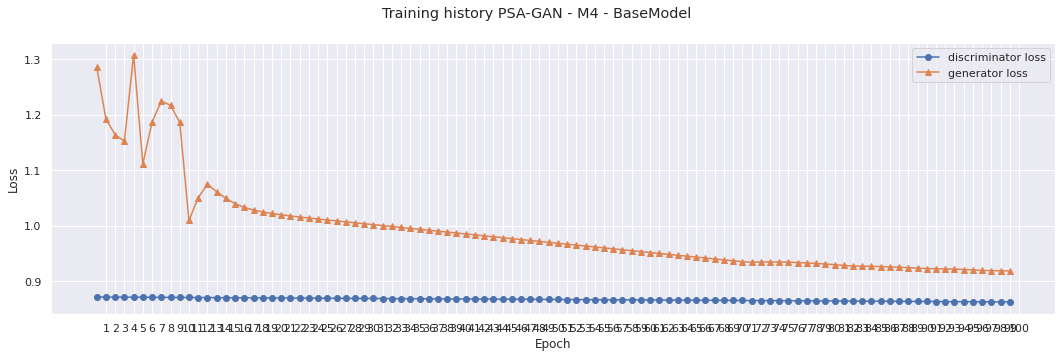

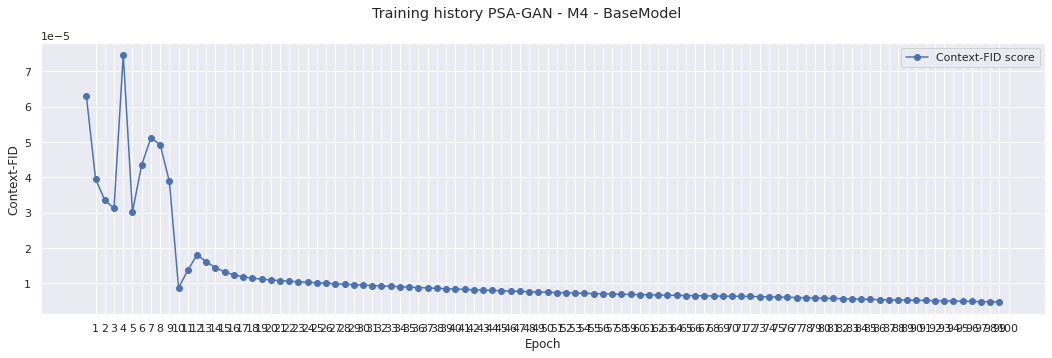

In [71]:
train = TensorDataset(trainX[:64,:,:], sequences_train[:64,:,:])
history = pipline(train_data=train, plot_history=True)